## Principal Components Analysis (PCA)

In [2]:
library(datasets)
library(scatterplot3d)

In [3]:
N <- 100
SD <- 3

x <- rnorm(N, sd=SD / 2)
noise <- rnorm(N, sd=SD)
y <- 1.3 + 1.77*x + noise
#y <- rnorm(N, mean=1, sd=SD)

In [4]:
layout.m <- matrix(c(rep(1, 4), 2, rep(c(rep(3, 4), 4), 4)), ncol=5)
layout.m

1,3,3,3,3
1,3,3,3,3
1,3,3,3,3
1,3,3,3,3
2,4,4,4,4


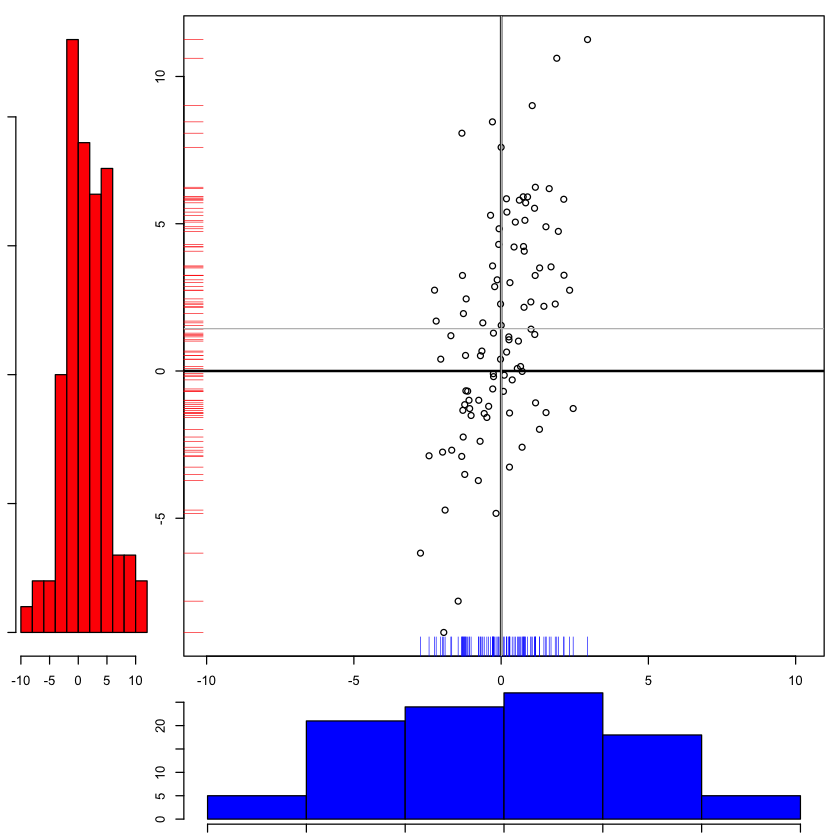

In [5]:
layout(layout.m)
par(mar=c(1, 1, 1, 1))
hist(y, col=2, main='')
plot(0, type='n', axes=F)
plot(x, y, asp=1)
rug(x, col=4)
rug(y, side=2, col=2)
abline(h=0, lwd=2)
abline(v=0, lwd=2)
abline(h=mean(y), col='grey')
abline(v=mean(x), col='grey')
hist(x, col=4, main='')

In [6]:
var(x)

[1] 1.484604

In [7]:
var(y)

[1] 13.86607

The goal of PCA is to express the data set in fewer variables (i.e., "compress" the data), but do so in a way that minimizes loss.

Take the above data as an example.
We could simply drop one of the variables, and in this case, it would make more sense to retain the y-axis (red) variable as it retains more of the total variance than the x-axis (blue) variable.  But can we do better?

Imagine being able to hold the above image so that the x-y plane is parallel to the floor and spin it as if there were a pole rising from the floor and passing through the geometric center of the data (where the grey lines intersect).  From what angle would looking at it preserve the greatest variance?

To attempt to plot this assume this is now a bird's-eye view, and the arrows represent the tops of observers' heads, each with a different vantage point.  Which observer sees the maximum variance?

In [8]:
uniform.w.hole <- function(rmin, rmax, hmin, hmax) {
  side <- sample(c('a', 'b'), 1)
  if (side == 'a') {
    return(runif(1, rmin, hmin)  )
  } 
  return(runif(1, hmax, rmax))
}

In [9]:
create.random.observers <- function(n, x, y) {
  xs <- numeric(n)
  ys <- numeric(n)
  for (i in 1:n) {
    xs[i] <- uniform.w.hole(1.5 * min(x), 1.5 * max(x), min(x), max(x))
    ys[i] <- uniform.w.hole(1.5 * min(y), 1.5 * max(y), min(y), max(y))
  }
  data.frame(xs, ys)
}

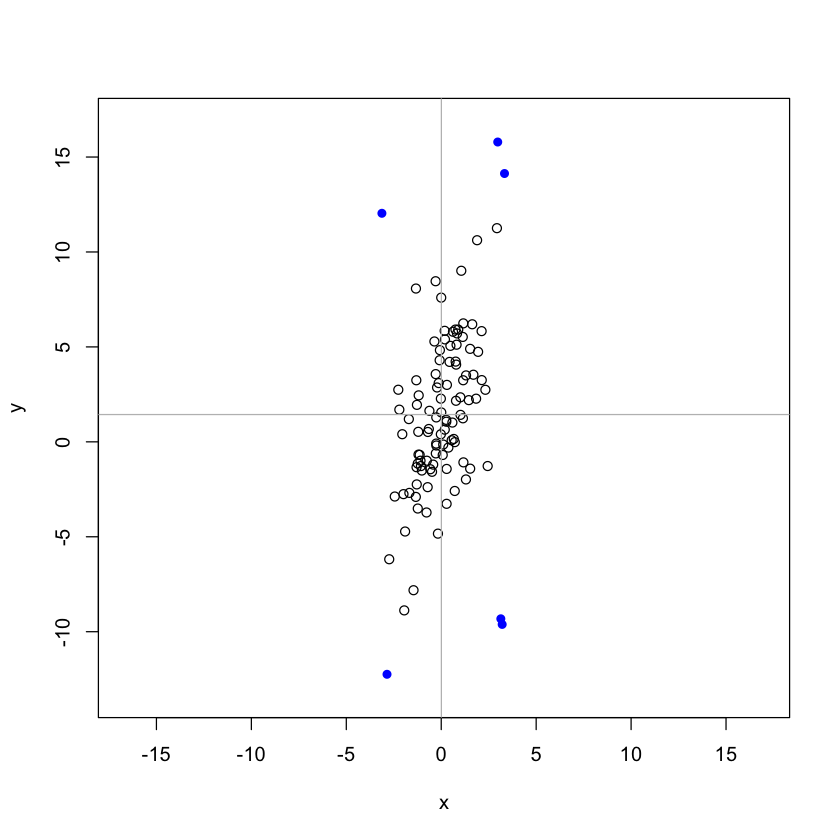

In [10]:
N_OBSERVERS <- 6
observers <- create.random.observers(N_OBSERVERS, x, y)
plot(x, y, asp=1, xlim=1.5*range(x), ylim=1.5*range(y))
abline(h=mean(y), col='grey')
abline(v=mean(x), col='grey')
points(observers$x, observers$y, pch=16, col=4)

So, the problem then is:
- Where is the optimal vantage point?
- How would you express this as a function of the data?

In [11]:
cipher <- function(text, rotation=13) {
  lower <- unlist(strsplit('abcdefghijklmnopqrstuvwxyz', ''))
  caps <- unlist(strsplit('ABCDEFGHIJKLMNOPQRSTUVWXYZ', ''))
  chars <- c(lower, caps)
  out <- ''
  for (char in unlist(strsplit(text, ''))) {
    idx <- which(chars == char)
    if (length(idx)) {
      repl <- chars[(idx + rotation) %% length(chars)]
      out <- paste0(out, repl)
    } else {
      out <- paste0(out, char)
    }
  }
  out
}

In [12]:
cipher('UBJ noBHG Gur ErtErFFvBA yvAr?', -13)

[1] "How about the regression line?"

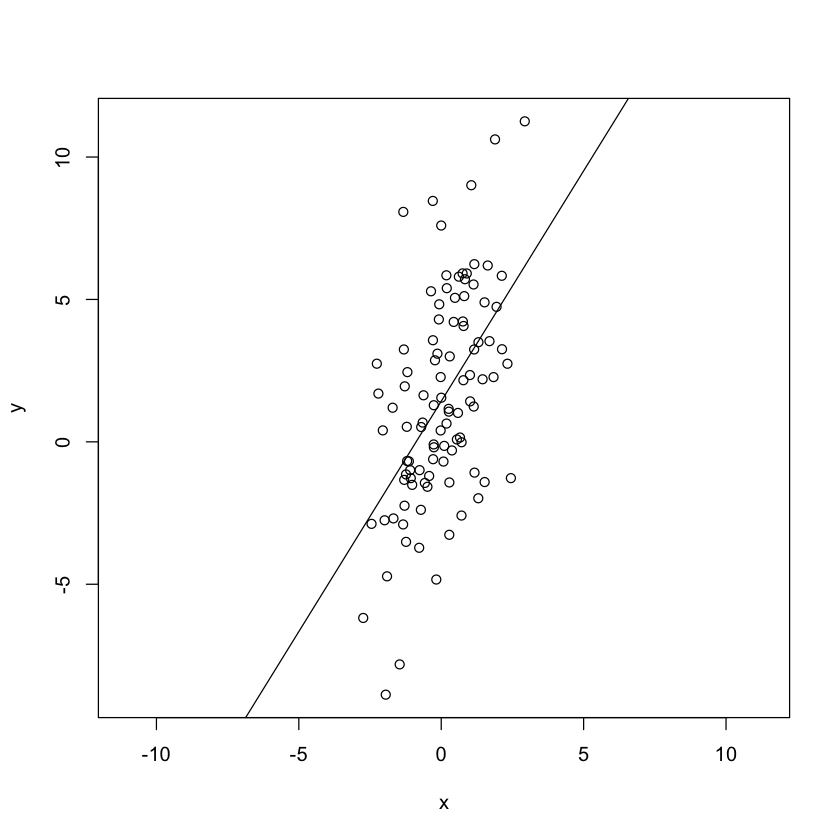

In [13]:
mod <- lm(y ~ x)
plot(x, y, asp=1)
abline(mod)

In [14]:
cipher('UBJ vF GuvF yvAr? junG vF Gur CEBoyrz JvGu GuvF BAr?', -13)
cipher('UvAG:', -13)

[1] "How is this line? What is the problem with this one?"

[1] "Hint:"

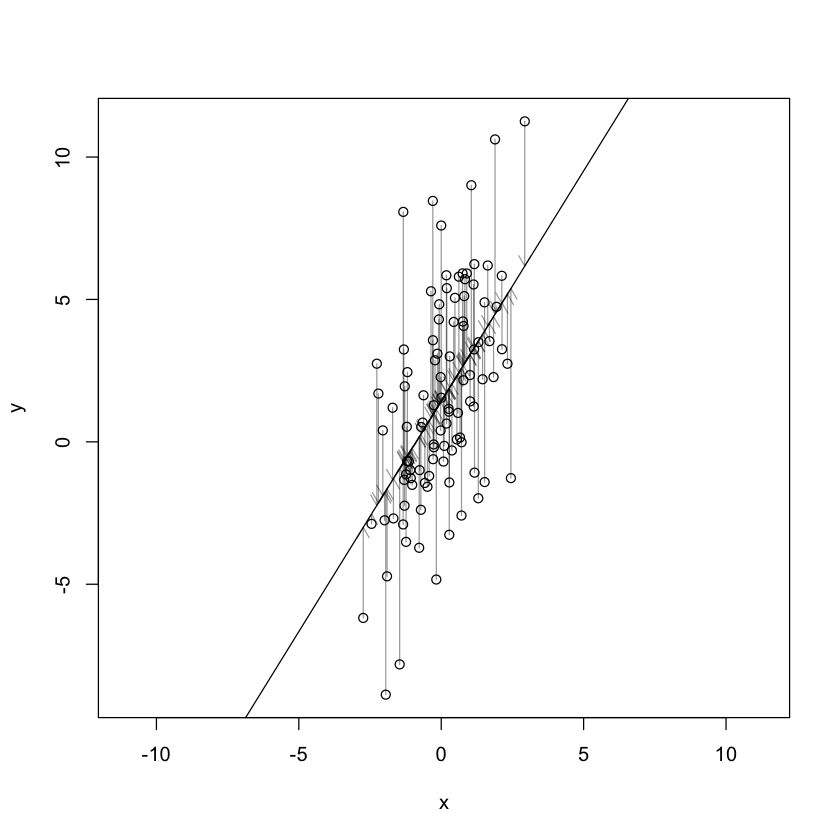

In [15]:
mod <- lm(y ~ x)
plot(x, y, asp=1)
abline(mod)
arrows(x, y, x, fitted(mod), length=0.1, col=rgb(0, 0, 0, 0.4))

In [16]:
cipher(paste(
  'gur yBFF sHApGvBA vA ErtErFFvBA zvAvzvMrF Gur rEEBE, BE Gur IrEGvpny',
  'qvFGnApr sEBz Gur yvAr nyBAt Gur L nKvF.  junG Jr ErnyyL JnAG vF n',
  'yvAr GunG zvAvzvMrF Gur qvFGnApr CrECrAqvpHynE GB GunG yvAr.'), 
  -13)

[1] "The loss function in regression minimizes the error, or the vertical distance from the line along the y axis.  What we really want is a line that minimizes the distance perpendicular to that line."

In [17]:
project <- function(x, y, b, m) {
  A <- matrix(c(-m, 1/m, 1, 1), nrow=2)
  b.vec <- c(b, (x + m*y) / m)
  solve(A, b.vec)
}

In [18]:
proj.x <- proj.y <- numeric(length(x))
for (i in 1:length(x)) {
  projection <- project(x[i], y[i], coef(mod)[1], coef(mod)[2])
  proj.x[i] <- projection[1]
  proj.y[i] <- projection[2]
}

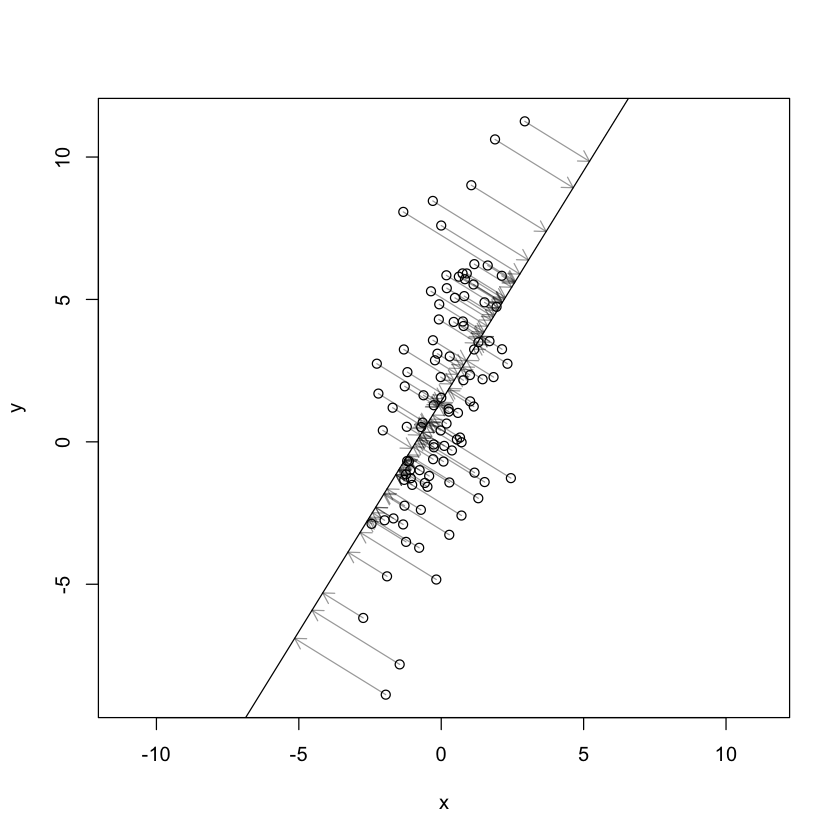

In [19]:
mod <- lm(y ~ x)
plot(x, y, asp=1)
abline(mod)
arrows(x, y, proj.x, proj.y, length=0.1, col=rgb(0, 0, 0, 0.4))

Hopefully this example is such that it should be obvious from eyeballing this plot that the regression line is not optimal for this criterion.  We should be able to "spin" the line counter-clockwise a bit and get a better fit.

In principle, you could write a loss function to minimize this distance, and then run gradient descent as we have seen for fitting regression lines, but it turns out there is a simpler solution.

If you haven't done much linear algebra, or are a little rusty, you can ignore this, but it turns out that the best line here is descibed by the first eigenvector.  We can obtain this vector (and higher order eigenvectors) very efficiently using single value decomposition (SVD):

In [20]:
X <- cbind(x, y)
decomp <- svd(X)
eigenvals <- decomp$d
eigenvecs <- decomp$v
eigenvals; eigenvecs

[1] 40.22714 10.40289

-0.1602173,0.9870818
-0.9870818,-0.1602173


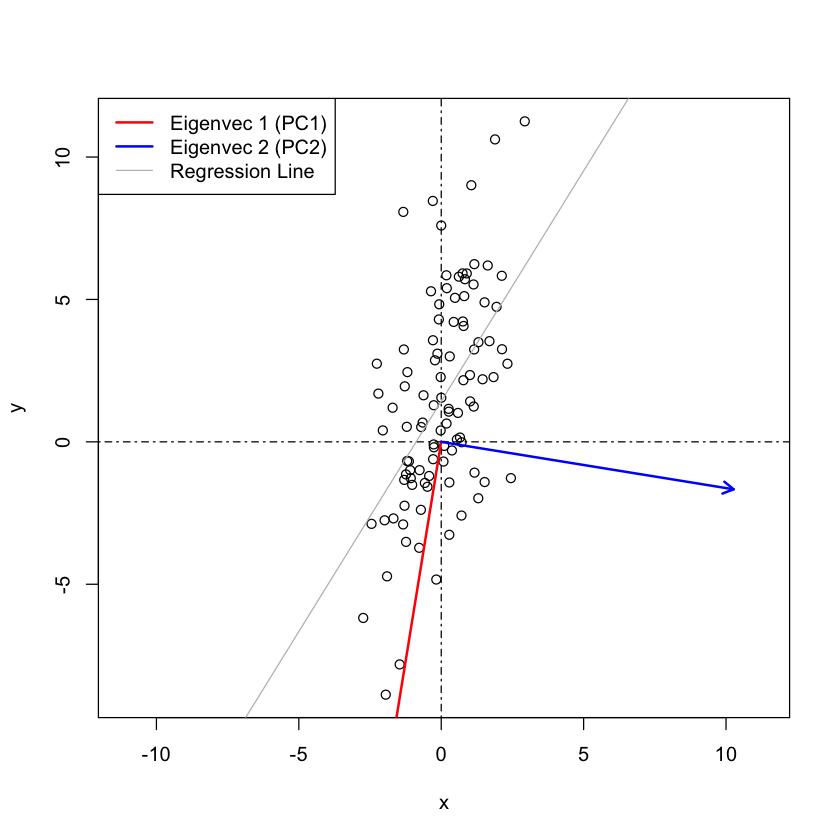

In [21]:
mod <- lm(y ~ x)
plot(x, y, asp=1)
abline(h=0, lty=4)
abline(v=0, lty=4)
abline(mod, col='grey')
arrows(0, 
       0, 
       eigenvals[1]*eigenvecs[1, 1], 
       eigenvals[1]*eigenvecs[2, 1], 
       col=2, 
       length=0.1, 
       lw=2)
arrows(0, 
       0, 
       eigenvals[2]*eigenvecs[1, 2], 
       eigenvals[2]*eigenvecs[2, 2], 
       col=4, 
       length=0.1, 
       lw=2)
legend('topleft', 
       lwd=c(2, 2, 1), 
       col=c('red', 'blue', 'grey'), 
       legend=c('Eigenvec 1 (PC1)', 'Eigenvec 2 (PC2)', 'Regression Line'))

Recall that a vector is location agonstic, so to perfectly describe the line, set the tails of the vectors at the center of the cluster (mean(x), mean(y))

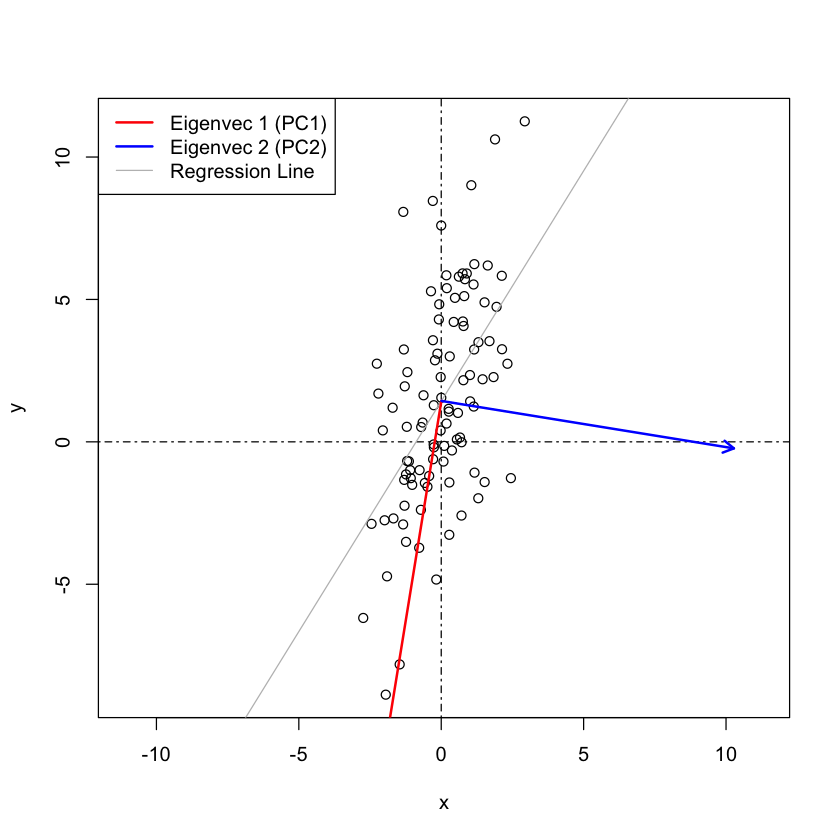

In [22]:
mod <- lm(y ~ x)
plot(x, y, asp=1)
abline(h=0, lty=4)
abline(v=0, lty=4)
abline(mod, col='grey')
arrows(mean(x), 
       mean(y), 
       eigenvals[1]*eigenvecs[1, 1] + mean(x), 
       eigenvals[1]*eigenvecs[2, 1] + mean(y), 
       col=2, 
       length=0.1, 
       lw=2)
arrows(mean(x), 
       mean(y),  
       eigenvals[2]*eigenvecs[1, 2] + mean(x),
       eigenvals[2]*eigenvecs[2, 2] + mean(y), 
       col=4, 
       length=0.1, 
       lw=2)
legend('topleft', 
       lwd=c(2, 2, 1), 
       col=c('red', 'blue', 'grey'), 
       legend=c('Eigenvec 1 (PC1)', 'Eigenvec 2 (PC2)', 'Regression Line'))

In [24]:
pca <- princomp(X)

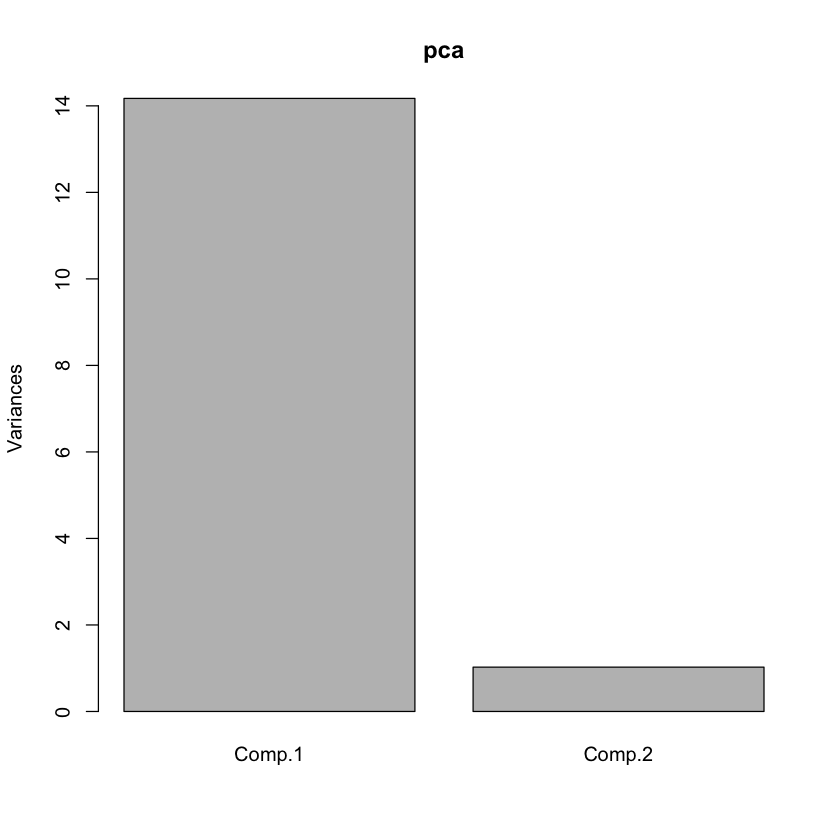

In [25]:
plot(pca)

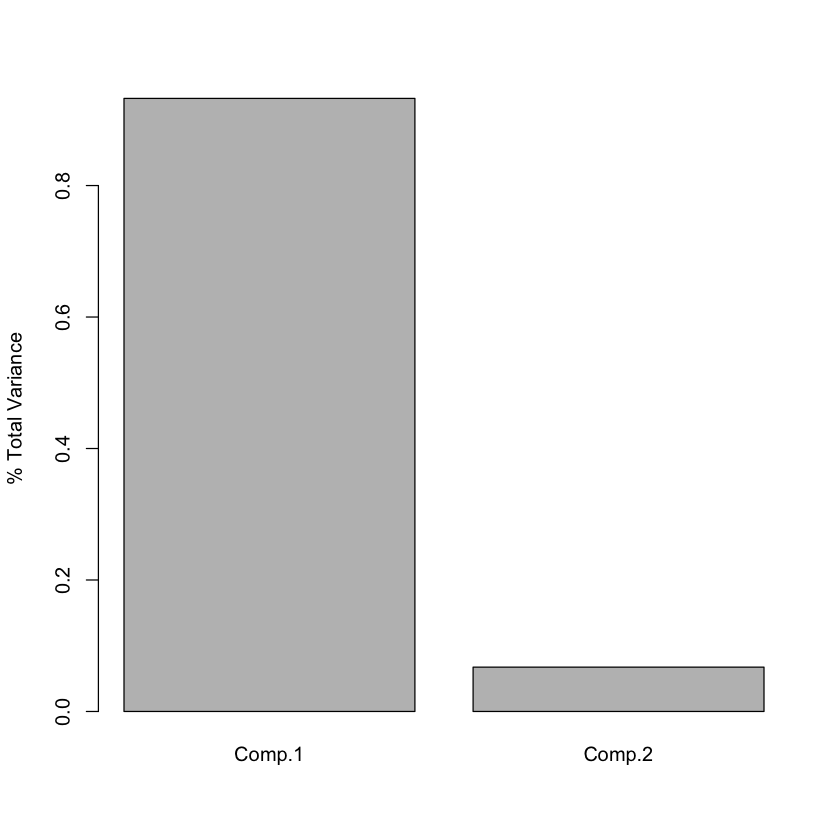

In [26]:
total.var <- sum(pca$sdev^2)
pc.vars <- pca$sdev^2 / total.var
barplot(pc.vars, ylab='% Total Variance')

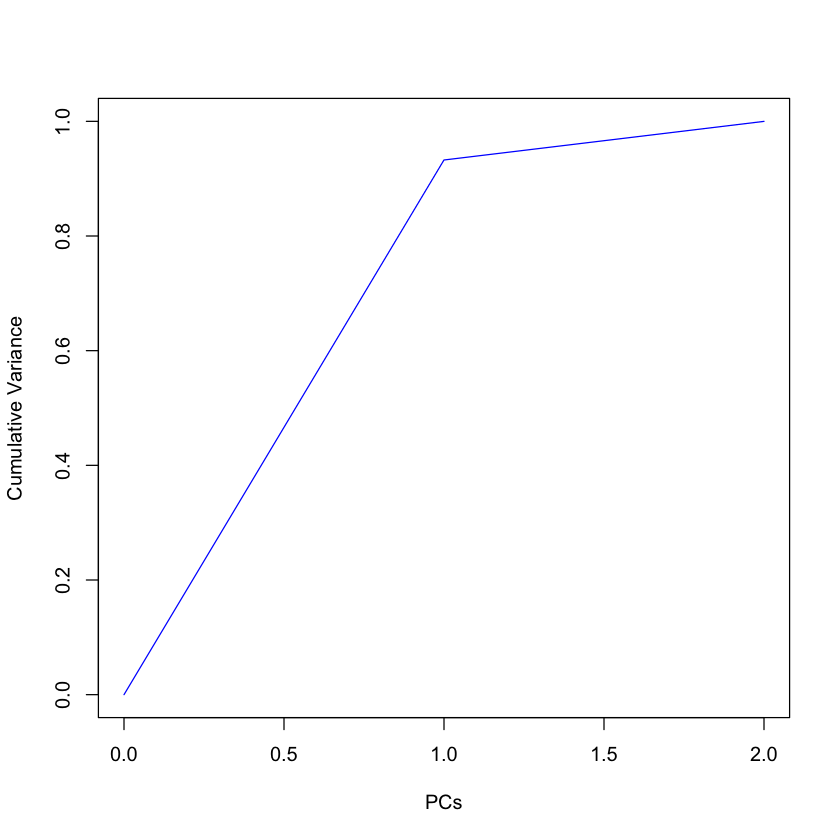

In [27]:
plot(c(0:2), 
     c(0, cumsum(pc.vars)), 
     col=4, 
     type='l', 
     xlab='PCs', 
     ylab='Cumulative Variance')

In [28]:
head(pca$scores)

Comp.1,Comp.2
9.3706412,0.16057481
4.5609315,0.05119569
-0.2285403,0.30053284
-0.3083872,0.64786785
2.7282533,0.28049113
-3.1222258,1.90083852


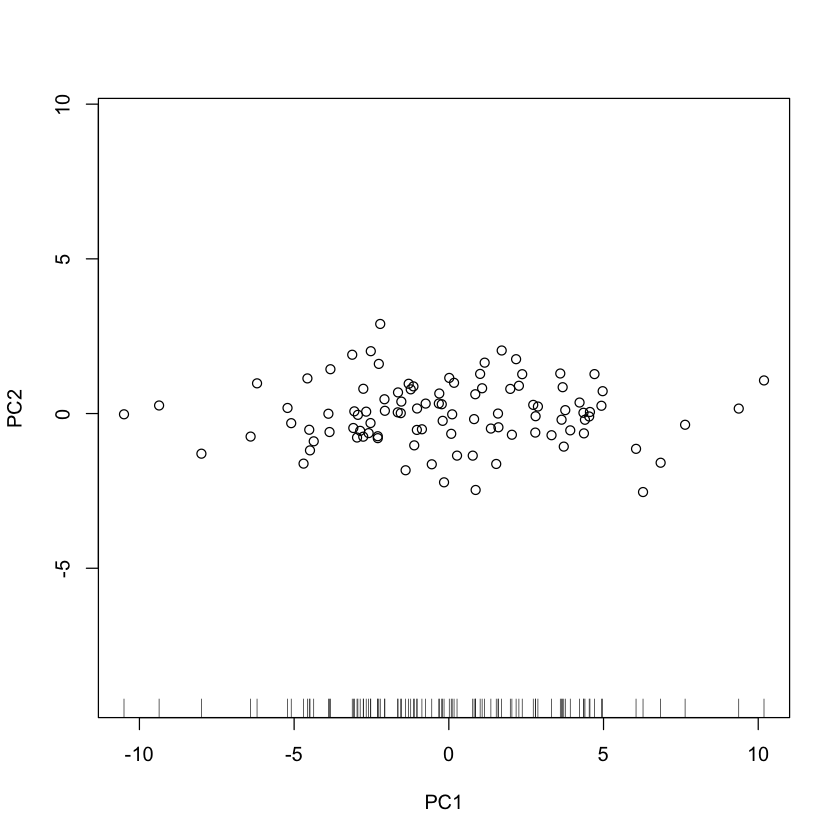

In [29]:
plot(pca$scores[, 1], pca$scores[, 2], asp=1, xlab='PC1', ylab='PC2')
rug(pca$scores[, 1], col=1)

In [30]:
pca$loadings


Loadings:
  Comp.1 Comp.2
x  0.184  0.983
y  0.983 -0.184

               Comp.1 Comp.2
SS loadings       1.0    1.0
Proportion Var    0.5    0.5
Cumulative Var    0.5    1.0

In [31]:
data(iris)
head(iris)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


In [32]:
iris.scaled <- as.data.frame(scale(iris[, 1:4]))
iris.scaled$Species <- iris$Species
iris <- iris.scaled
head(iris)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
-0.8976739,1.01560199,-1.335752,-1.311052,setosa
-1.1392005,-0.13153881,-1.335752,-1.311052,setosa
-1.3807271,0.32731751,-1.392399,-1.311052,setosa
-1.5014904,0.09788935,-1.279104,-1.311052,setosa
-1.0184372,1.24503015,-1.335752,-1.311052,setosa
-0.5353840,1.93331463,-1.165809,-1.048667,setosa


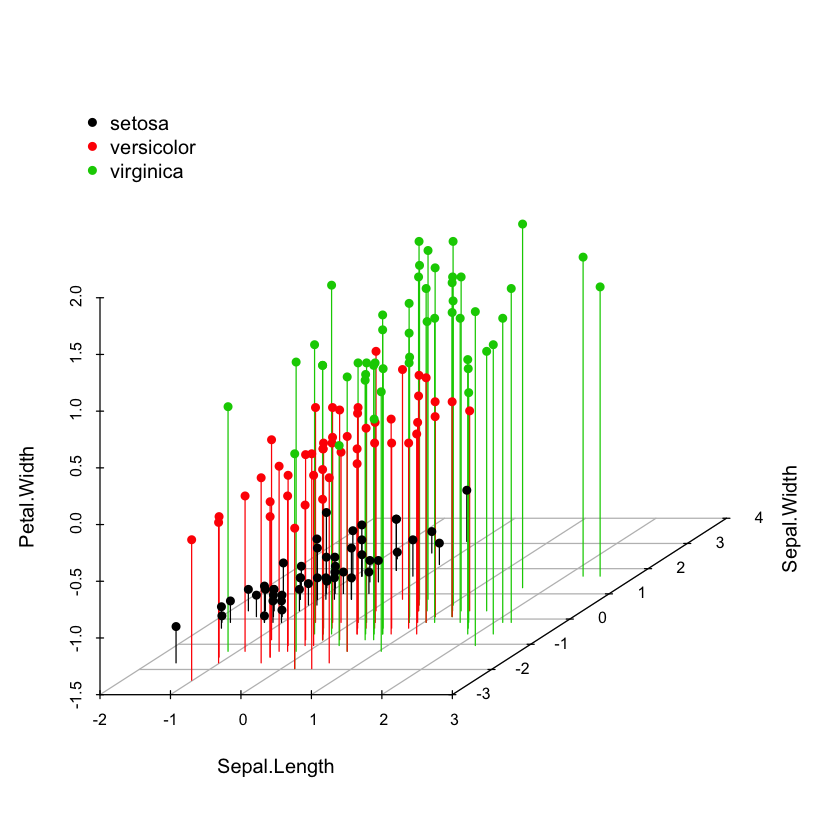

In [33]:
# To allow us to visualize, let's plot just 3 of the 4 variables available
USE_COLS <- c(1, 2, 4)
scatterplot3d(iris[, USE_COLS], 
              type='h', 
              pch=16, 
              color=as.numeric(iris$Species), 
              box=F)
legend('topleft', pch=16, col=1:3, legend=levels(iris$Species), bty='n')

So how can we optimally represent these data in 2D?

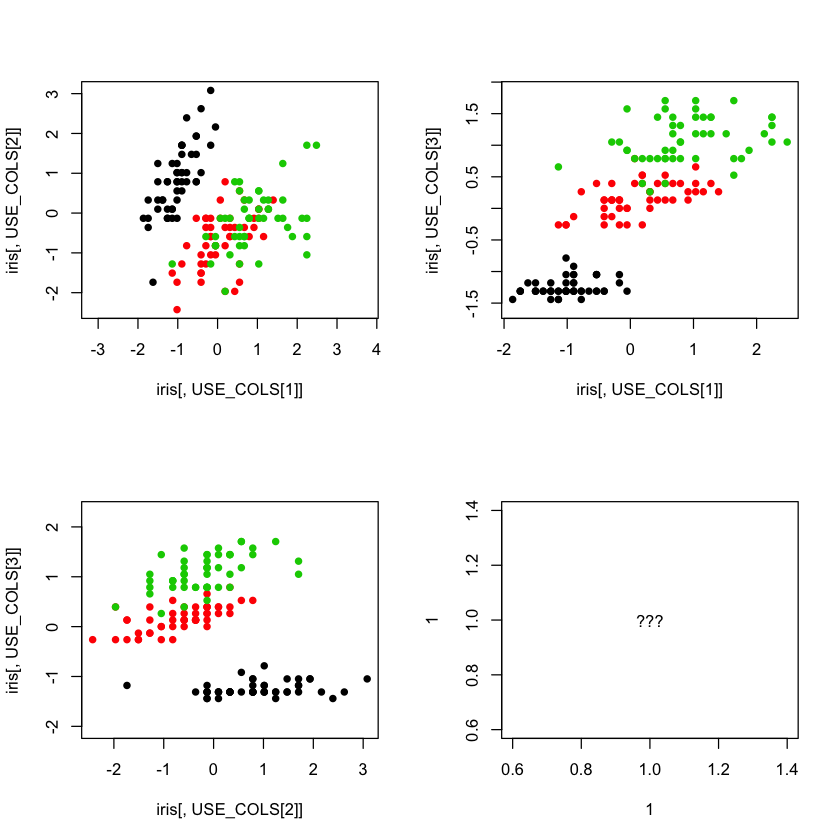

In [34]:
par(mfrow=c(2, 2))
plot(iris[, USE_COLS[1]], 
     iris[, USE_COLS[2]], 
     pch=16, 
     col=as.numeric(iris$Species),
     asp=1)
plot(iris[, USE_COLS[1]], 
     iris[, USE_COLS[3]], 
     pch=16, 
     col=as.numeric(iris$Species),
     asp=1)
plot(iris[, USE_COLS[2]], 
     iris[, USE_COLS[3]], 
     pch=16, 
     col=as.numeric(iris$Species),
     asp=1)
plot(1, 1, type='n')
text(1, 1, '???')

In [35]:
pca <- princomp(iris[, USE_COLS])

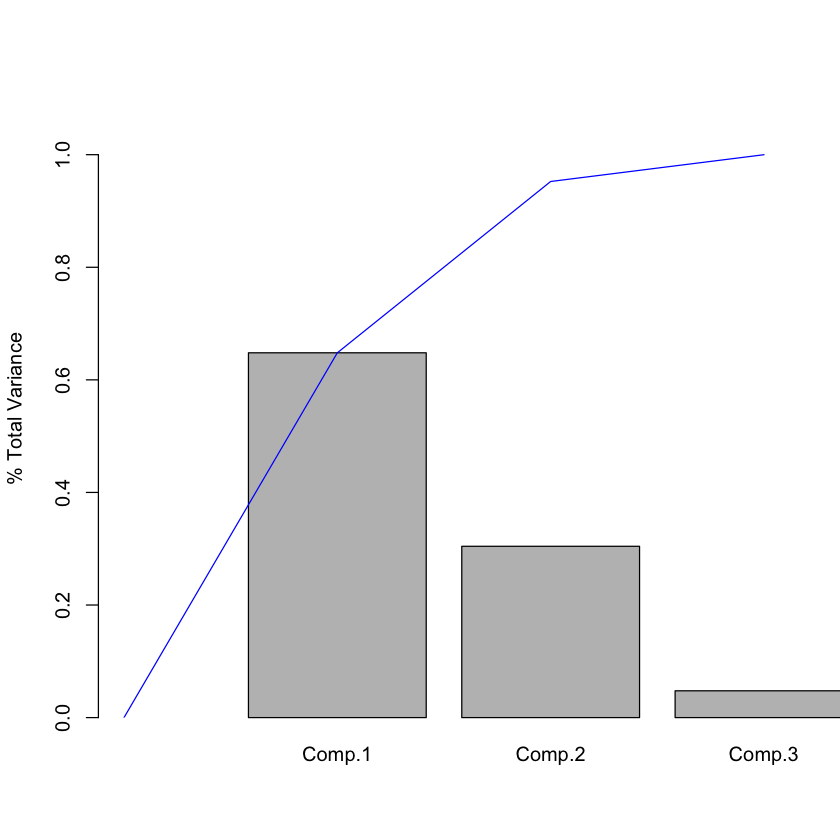

In [36]:
total.var <- sum(pca$sdev^2)
pc.vars <- pca$sdev^2 / total.var

W = 1
GAP = 0.2
SPACE = W + GAP
b1 <- GAP + W / 2
xlocs <- b1 + c(-1:2)*SPACE
barplot(
  pc.vars, ylab='% Total Variance', xlim=range(xlocs), ylim=c(0, 1.1))
lines(xlocs,
      c(0, cumsum(pc.vars)), 
      col=4, 
      type='l', 
      xlab='PCs', 
      ylab='Cumulative Variance')

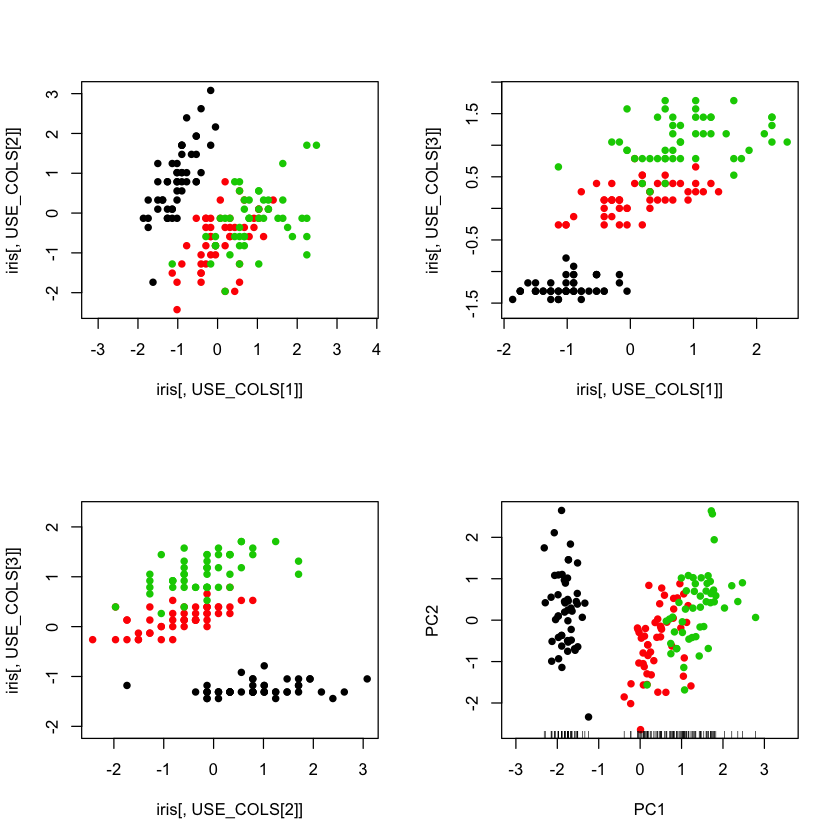

In [37]:
par(mfrow=c(2, 2))
plot(iris[, USE_COLS[1]], 
     iris[, USE_COLS[2]], 
     pch=16, 
     col=as.numeric(iris$Species),
     asp=1)
plot(iris[, USE_COLS[1]], 
     iris[, USE_COLS[3]], 
     pch=16, 
     col=as.numeric(iris$Species),
     asp=1)
plot(iris[, USE_COLS[2]], 
     iris[, USE_COLS[3]], 
     pch=16, 
     col=as.numeric(iris$Species),
     asp=1)
plot(pca$scores[, 1], 
     pca$scores[, 2], 
     asp=1, 
     xlab='PC1', 
     ylab='PC2', 
     pch=16,
     col=as.numeric(iris$Species))
rug(pca$scores[, 1], col=1)

In [38]:
var(iris[, USE_COLS[1]])
var(iris[, USE_COLS[2]])
var(iris[, USE_COLS[3]])
var(pca$scores[, 1])

[1] 1

[1] 1

[1] 1

[1] 1.944181

But we can even compress _all 4_ dimensions into just 2.  (Typically we would say "project the data onto the first two PCs")

In [39]:
pca <- princomp(iris[, 1:4])

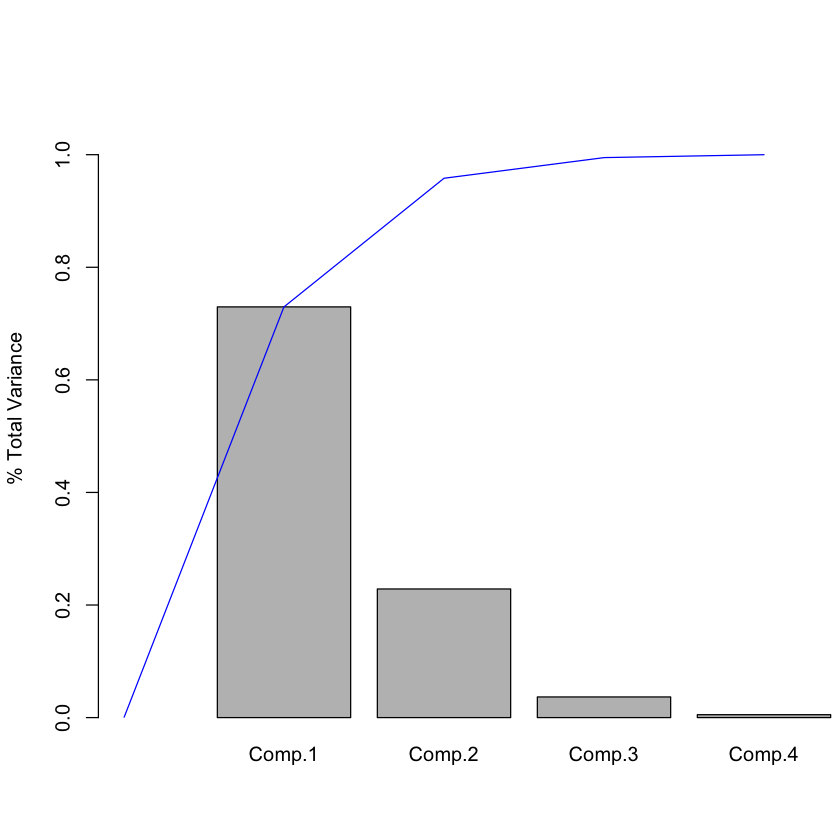

In [40]:
total.var <- sum(pca$sdev^2)
pc.vars <- pca$sdev^2 / total.var

xlocs <- b1 + c(-1:3)*SPACE
barplot(
  pc.vars, ylab='% Total Variance', xlim=range(xlocs), ylim=c(0, 1.1))
lines(xlocs,
      c(0, cumsum(pc.vars)), 
      col=4, 
      type='l', 
      xlab='PCs', 
      ylab='Cumulative Variance')

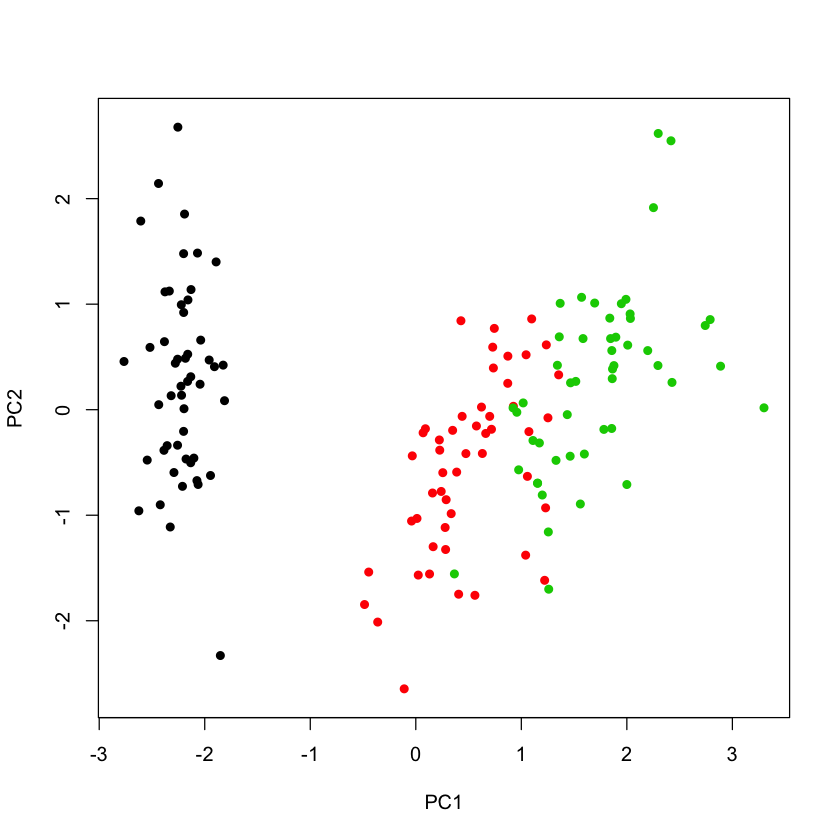

In [41]:
plot(pca$scores[, 1], 
     pca$scores[, 2], 
     asp=1, 
     xlab='PC1', 
     ylab='PC2', 
     pch=16,
     col=as.numeric(iris$Species))

In [42]:
pca$loadings


Loadings:
             Comp.1 Comp.2 Comp.3 Comp.4
Sepal.Length  0.521  0.377  0.720  0.261
Sepal.Width  -0.269  0.923 -0.244 -0.124
Petal.Length  0.580        -0.142 -0.801
Petal.Width   0.565        -0.634  0.524

               Comp.1 Comp.2 Comp.3 Comp.4
SS loadings      1.00   1.00   1.00   1.00
Proportion Var   0.25   0.25   0.25   0.25
Cumulative Var   0.25   0.50   0.75   1.00

In [43]:
N <- 99
x <- y <- z <- runif(N)
df <- data.frame(x, y, z)

In [44]:
make.random.vec <- function(df, cname) {
  coefs1 <- runif(3, -10, 10)
  coefs2 <- runif(3, -10, 10)
  coefs3 <- runif(3, -10, 10)
  v1 <- as.matrix(df[1:33, c('x', 'y', 'z')]) %*% coefs1 + 
    rnorm(33, sd=runif(1, 1, 6))
  v2 <- as.matrix(df[34:66, c('x', 'y', 'z')]) %*% coefs2 + 
    rnorm(33, sd=runif(1, 1, 6))
  v3 <- as.matrix(df[67:99, c('x', 'y', 'z')]) %*% coefs3 + 
    rnorm(33, sd=runif(1, 1, 6))
  df <- cbind(df, c(v1, v2, v3))
  names(df)[ncol(df)] <- cname
  df
}

In [45]:
for (i in 1:25) {
  df <- make.random.vec(df, cname=i)
}
df$labels <- c(rep(1, 33), rep(2, 33), rep(3, 33))

In [46]:
head(df)

x,y,z,1,2,3,4,5,6,7,⋯,17,18,19,20,21,22,23,24,25,labels
0.44746157,0.44746157,0.44746157,8.9615411,-10.812074,2.620543,2.38586598,-8.8481226,2.4225469,3.7428740,⋯,-0.1309144,8.5459087,-8.8389011,-3.910968,2.8337424,-8.8187172,-15.242641,2.506780,7.941700,1
0.10559787,0.10559787,0.10559787,-2.9542965,-8.208490,2.536179,1.74787200,7.6614528,0.8108573,6.0930094,⋯,2.5557479,-0.4309931,-4.0132708,-4.077786,5.9365387,-7.2997629,-2.617026,1.255546,1.530467,1
0.40577245,0.40577245,0.40577245,9.9724828,-8.282299,11.790839,-0.18214878,0.4566187,7.4975121,5.1806477,⋯,4.6912859,8.4098604,-5.8113778,-9.659105,5.4220500,-3.0105558,-3.193208,7.627706,5.052133,1
0.76714241,0.76714241,0.76714241,3.9679027,-14.767972,12.363850,0.38999123,-8.2590605,6.2471656,6.2084837,⋯,15.2981386,19.0145764,-8.9823750,-10.030182,7.1511323,-9.4810623,-2.469166,3.232902,8.463435,1
0.51973295,0.51973295,0.51973295,3.7141596,-7.801457,-4.360404,-0.76878400,-3.9725740,3.9958824,8.5004849,⋯,4.0962181,8.6958619,-6.3994041,-10.572201,3.6868835,0.9890447,2.197474,11.073946,8.748734,1
0.07101637,0.07101637,0.07101637,-0.8729514,-5.494826,-4.822811,0.00155366,7.6414253,-2.2881525,-0.6761524,⋯,-6.4250726,5.1830512,-0.5808356,0.624932,0.1680484,-0.3185756,-6.683342,4.751586,-8.221428,1


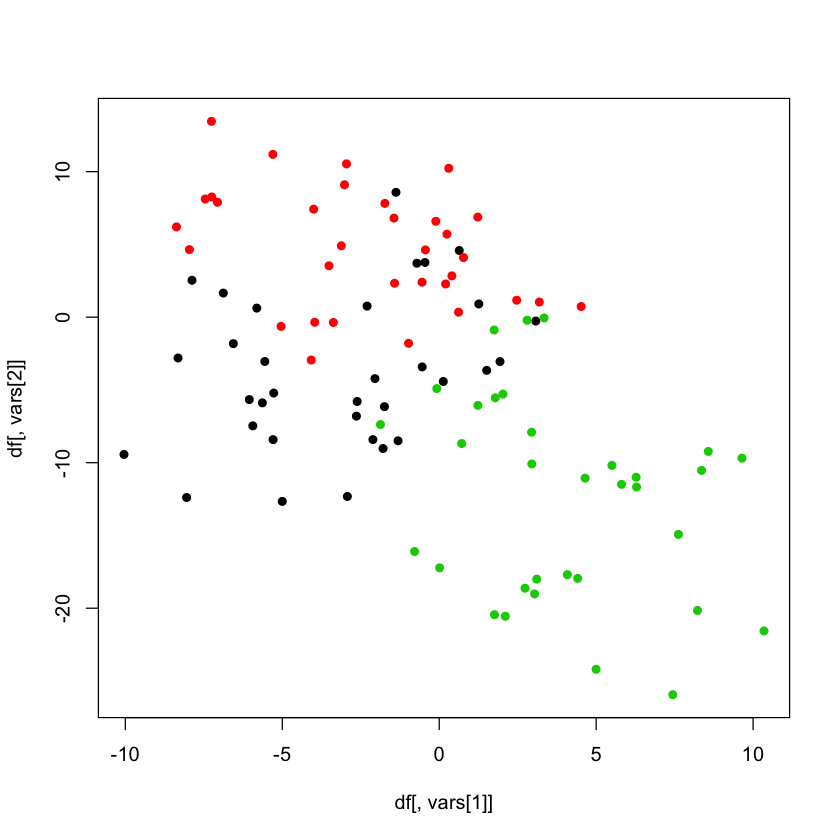

In [48]:
# First, let's just randomly plot any pairs of columns
vars <- sample(names(df)[4:28], 2)
plot(df[, vars[1]], df[, vars[2]], col=df$labels, pch=16)

In [49]:
pca <- princomp(df[, 4:28])

[1] 25

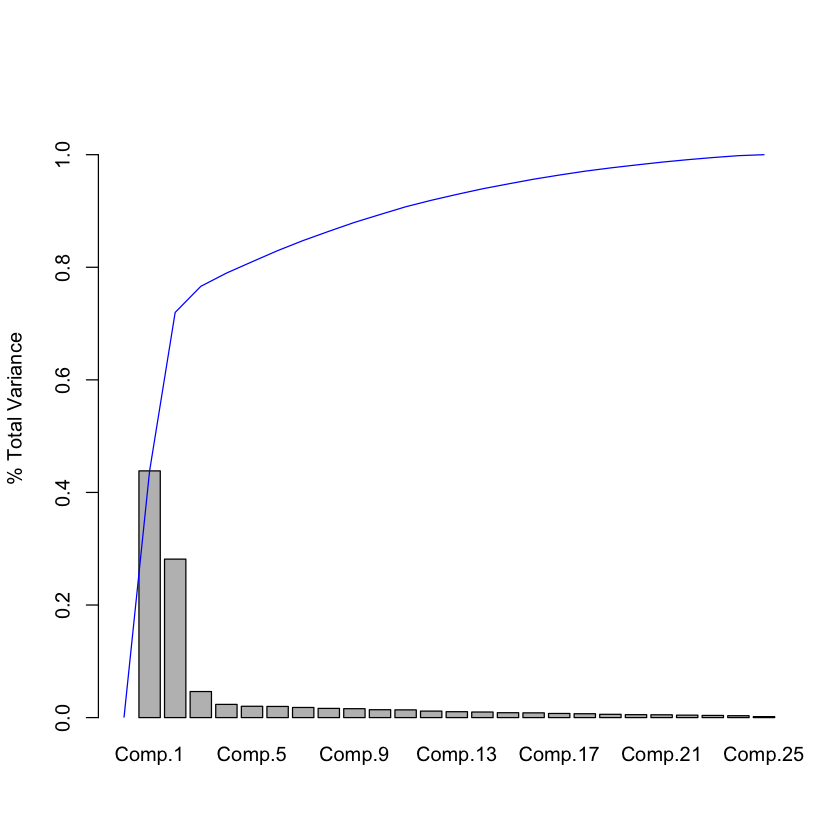

In [50]:
total.var <- sum(pca$sdev^2)
pc.vars <- pca$sdev^2 / total.var
length(pc.vars)

xlocs <- b1 + c(-1:24)*SPACE
barplot(
  pc.vars, ylab='% Total Variance', xlim=range(xlocs), ylim=c(0, 1.1))
lines(xlocs,
      c(0, cumsum(pc.vars)), 
      col=4, 
      type='l', 
      xlab='PCs', 
      ylab='Cumulative Variance')

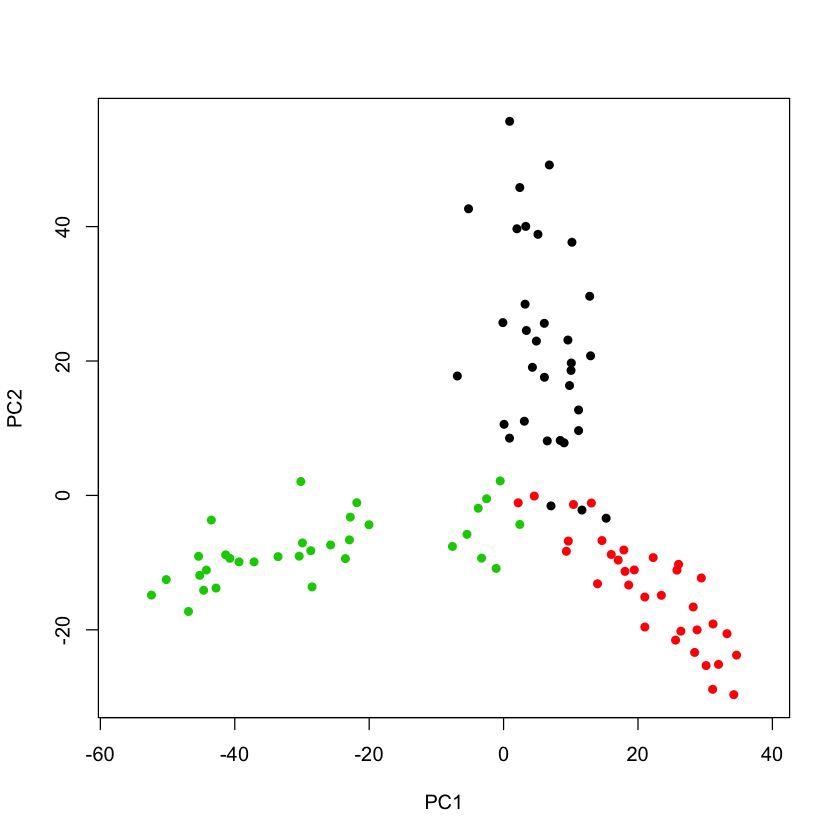

In [51]:
plot(pca$scores[, 1], 
     pca$scores[, 2], 
     asp=1, 
     xlab='PC1', 
     ylab='PC2', 
     pch=16,
     col=as.numeric(df$labels))

In [52]:
pca$loadings


Loadings:
   Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6 Comp.7 Comp.8 Comp.9 Comp.10
1   0.104  0.110  0.165  0.356         0.439         0.113  0.116  0.312 
2         -0.277        -0.202        -0.104        -0.260 -0.491 -0.299 
3          0.240  0.173                0.250  0.542 -0.109        -0.256 
4  -0.111 -0.180  0.463  0.165         0.243        -0.236               
5         -0.243 -0.171                       0.390        -0.146        
6  -0.271         0.334                                     0.415 -0.206 
7   0.121                0.123 -0.146 -0.214                       0.153 
8   0.264 -0.412                       0.197  0.122                      
9                 0.289        -0.107         0.143 -0.171        -0.187 
10 -0.161                                                                
11 -0.195  0.311         0.109                      -0.405  0.321 -0.272 
12  0.162  0.161                      -0.104 -0.388               -0.226 
13  0.126  0.114  0.118 -0.